# DEA CoastLines validation

## Load modules/functions


In [6]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import glob
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from shapely.geometry import box
import geopandas as gpd

import deacoastlines_validation as deacl_val

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Pre-processing

### NSW Beach Profile Database



In [5]:
for fname in glob.glob('input_data/nswbpd/*.csv')[0:10]:
    deacl_val.preprocess_nswbpd(fname)      


/g/data1a/r78/rt1527/dea-notebooks/MAHTS/validation/deacoastlines_validation.py:37: RuntimeWarning: invalid value encountered in true_divide
  x = Dx / D
/g/data1a/r78/rt1527/dea-notebooks/MAHTS/validation/deacoastlines_validation.py:38: RuntimeWarning: invalid value encountered in true_divide
  y = Dy / D


/g/data/v10/public/modules/dea-env/20200313/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3254: DtypeWarning: Columns (1) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


## Analysis

In [21]:
# Load validation data
shoreline_dist = pd.read_csv(f'output_data/nswbpd_vallabeach.csv', parse_dates=['date'])

# Get bounding box to load data for
minx, maxy = shoreline_dist.min().loc[['0_x', '0_y']]
maxx, miny = shoreline_dist.max().loc[['0_x', '0_y']]
bbox = gpd.GeoSeries(box(minx, miny, maxx, maxy), crs='EPSG:28356')

# Import corresponding waterline contours
contours_gdf = gpd.read_file(f'../packages/DEACoastLines_v0.2.0/DEACoastLines_coastlines_v0.2.0.shp', 
                             bbox=bbox).to_crs(epsg=28356) 
contours_gdf['year'] = contours_gdf.year.astype('int64')


# Add year column
shoreline_dist['year'] = shoreline_dist.date.dt.year

# Aggregate by year and save count number
counts = shoreline_dist.groupby(['year', 'site']).count().date
shoreline_dist = shoreline_dist.groupby(['year', 'site']).median()
shoreline_dist['n'] = counts
shoreline_dist = shoreline_dist.reset_index()

from shapely.geometry import Point, LineString
shoreline_geometry = shoreline_dist.apply(lambda x: 
                                           LineString([Point(x.start_x, x.start_y), 
                                                       Point(x.end_x, x.end_y)]), axis=1)

shoreline_gdf = gpd.GeoDataFrame(shoreline_dist, 
                                 geometry=shoreline_geometry, 
                                 crs='EPSG:28356').reset_index()

# Combine to match each shoreline contour to each date in validation data
merge_test = shoreline_gdf.merge(contours_gdf, on='year', suffixes=('_val', '_deacl'))

# For each row, compute distance between origin and location where profile intersects with waterline contour
merge_test['Landsat beach width (m)'] = merge_test.apply(lambda x: x.geometry_val.intersection(x.geometry_deacl).hausdorff_distance(Point(x.start_x, x.start_y)), axis=1)
merge_test = merge_test.rename({'0_dist': 'Validation beach width (m)'}, axis=1)
merge_test = merge_test[merge_test['Landsat beach width (m)'] > 0]
merge_test = merge_test[merge_test['Validation beach width (m)'] > 0]

# Optional corrections
# merge_test['Landsat beach width (m)'] = merge_test['Landsat beach width (m)'] + 15

# Calculate difference
merge_test['Difference'] = (merge_test['Validation beach width (m)'] - 
                            merge_test['Landsat beach width (m)'])

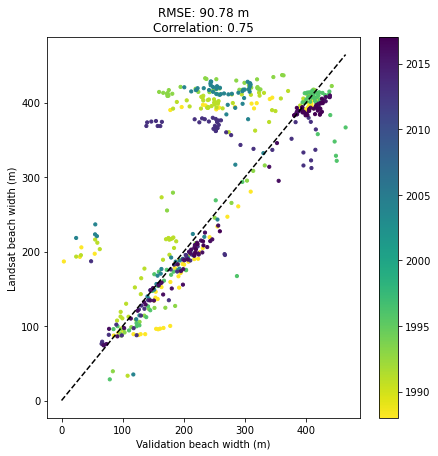

In [22]:
from sklearn.metrics import mean_squared_error

# Extract data to plot
plot_df = merge_test[['Validation beach width (m)', 'Landsat beach width (m)']]

# Calculate stats
rmse = mean_squared_error(merge_test['Validation beach width (m)'], 
                          merge_test['Landsat beach width (m)'])**0.5
cor = plot_df.corr().iloc[0, 1]

# Plot image
fig, ax = plt.subplots(figsize=(7, 7))
plot_df.plot.scatter(x='Validation beach width (m)', 
                     y='Landsat beach width (m)', 
                     c=merge_test.year, 
                     s=10, 
                     cmap='viridis_r', 
                     ax=ax)  
plt.plot(np.linspace(0, plot_df.max(axis=0).max()), 
         np.linspace(0, plot_df.max(axis=0).max()), 
         'black', 
         linestyle='dashed')
plt.title(f'RMSE: {rmse:.2f} m\nCorrelation: {cor:.2f}');

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** March 2020